# **2. Model Selection**

Building a predictive model is just the beginning of the machine learning journey. To ensure that our model generalizes well to unseen data and doesn't just memorize the training set, we need **model selection** and **validation strategies**. In this notebook, we'll explore different approaches to split your dataset and evaluate model performance, which lead to the selection of the best model for deployment.

The way we split our data can significantly impact our model's performance assessment. We'll examine several techniques, from simple train-test splits to more sophisticated cross-validation methods, understanding when and why to use each approach.

<div class="alert alert-block alert-info">

## Table of Contents
### [1 - Data Setup](#setup)
* [1.1. - Loading Libraries](#libraries)
* [1.2. - Loading the Dataset](#data-loading)
### [2 - Holdout Method](#train-test)
* [2.1. - Creating Train and Test Sets](#train-test-split)
* [2.2. - Creating Train, Validation, and Test Sets](#three-way-split)
### [3 - Cross-Validation Techniques](#cross-validation)
* [3.1. - K-Fold Cross-Validation](#kfold)
* [3.2. - Repeated K-Fold Cross-Validation](#repeated-kfold)
* [3.3. - Leave-One-Out Cross-Validation](#loo)
* [3.4. - Other Techniques](#stratified)
### [4 - Comparing Models](#model-comparison)
* [4.1. - Decision Tree Classifier](#decision-tree)
* [4.2. - Model Comparison Results](#comparison-results)
### [5 - Hyperparameter Tuning](#hyperparameter-tuning)
* [5.1. - What are Hyperparameters?](#what-are-hyperparameters)
* [5.2. - Grid Search with PredefinedSplit](#grid-search)
* [5.3. - Random Search with PredefinedSplit](#random-search)
* [5.4. - Comparing Tuning Strategies](#tuning-comparison)
</div>

<a class="anchor" id="setup">

## 1. Data Setup
</a>

Before we dive into different model selection techniques, we need to set up our environment and load the data. This section will prepare us for the experiments ahead.

<a class="anchor" id="libraries">

### 1.1. Loading Libraries
</a>

__`Step 1`__ Import the needed libraries

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

#simple preprocessing of datasets
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import PredefinedSplit

import warnings
warnings.filterwarnings('ignore')

np.random.seed(33)  # For reproducibility

<a class="anchor" id="data-loading">

### 1.2. Loading the Dataset
</a>

Throughout this notebook, we'll use a dataset from an online store called **Tugas**. 

__`Step 2`__ Read the dataset __tugas.xlsx__

In [21]:
tugas = pd.read_excel(r'./Datasets/tugas.xlsx')
# Removing datetime columns to avoid creating an excessive number of features with OHE
tugas = tugas.select_dtypes(exclude=['datetime64'])
tugas

,Custid,Year_Birth,Gender,Education,Marital_Status,Dependents,Income,Rcn,Frq,Mnt,...,Kitchen,SmallAppliances,HouseKeeping,Toys,NetPurchase,CatPurchase,Recomendation,CostPerContact,RevenuePerPositiveAnswer,DepVar
0,1003,1991,M,Graduation,NaN,1,29761.20,69,11,45.76,...,19,24,1,24,59,41,3,2,15,0
1,1004,1956,M,Master,Married,1,98249.55,10,26,923.52,...,10,19,6,5,35,65,5,2,15,0
2,1006,1983,F,PhD,Together,1,23505.30,65,14,58.24,...,2,48,2,1,67,33,4,2,15,0
3,1007,1970,F,Graduation,Single,1,72959.25,73,18,358.80,...,7,13,1,8,46,54,4,2,15,0
4,1009,1941,F,Graduation,Married,0,114973.95,75,30,1457.04,...,9,35,9,9,17,83,5,2,15,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,10989,1996,F,Basic,Single,1,29551.20,41,10,47.84,...,40,24,22,2,59,41,3,2,15,0
2496,10991,1940,F,Graduation,Married,0,132566.70,36,46,2320.24,...,4,47,9,8,22,78,6,2,15,0
2497,10993,1955,F,Graduation,Together,0,91768.95,1,25,870.48,...,8,27,8,1,47,53,4,2,15,0
2498,10994,1961,F,Basic,Married,1,99085.35,1,28,931.84,...,5,21,3,4,55,45,5,2,15,0


__`Step 3.1`__ Apply One-Hot Encoding to categorical variables

We can apply OHE to the entire dataset before splitting because it's deterministic - it just creates binary columns based on the categories present in the data. It doesn't learn statistics like means, frequencies, or anything from the target. If we were using CountEncoder or TargetEncoder, we'd need to fit only on training data because those encoders learn from the target variable or value frequencies, which would leak information from validation/test sets.

In [22]:
data = tugas.iloc[:,:-1]
target = tugas.iloc[:,-1]

In [23]:
# Separate categorical and numerical columns
categorical_cols = data.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = data.select_dtypes(include=[np.number]).columns.tolist()

# Apply OHE to categorical columns
ohe = OneHotEncoder(drop='first', sparse_output=False)
encoded_array = ohe.fit_transform(data[categorical_cols])
encoded_cols = ohe.get_feature_names_out(categorical_cols)

# Combine numerical and encoded categorical features
data_encoded = pd.concat([
    data[numerical_cols].reset_index(drop=True),
    pd.DataFrame(encoded_array, columns=encoded_cols)
], axis=1)

<a class="anchor" id="train-test">

## 2. Hold-Out (Train-Test-Validation) Split
</a>

The **holdout method** is the most model validation. The idea is simple: randomly divide your data into separate sets for training and testing. However, when we need to tune hyperparameters or compare multiple models, a simple train-test split is often not not enough. We need a third set - the **validation set** - to avoid data leakage and ensure honest model evaluation.

<a class="anchor" id="train-test-split">

### 2.1. Creating Train and Test Sets
</a>

In this approach we randomly split the complete data into **training** and **test** sets. Then perform the model training on the training set and use the test set for validation purposes. Ideally, we split the data into **70:30** or **80:20** ratios (specific ratios are not fixed but tend to be on this ballpark).

**Important Considerations:**
- **High variance** - the estimates depend on which samples end up in which set. This implies that, if data is not *i.i.d.* (something we tend to assume), different random splits can give quite different performance estimates.
- If our data is large and both sets have similar distributions, this approach is acceptable.
- **Stratification** of the target variable ensures that class proportions are maintained in both resulting sets (reduces variance): **Exclusive to classification problems**

By default, scikit-learn has a function named `train_test_split` that allows us to split the dataset into two different datasets.

__`Step 4`__ Import the library `train_test_split` from `sklearn.model_selection`

In [24]:
from sklearn.model_selection import train_test_split

<div class="alert alert-block alert-info">
<a href='https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html'>sklearn.model_selection.train_test_split(*arrays, test_size=None, train_size=None, random_state=None, shuffle=True, stratify=None)</a>

**Definition:**  
Split arrays or matrices into random train and test subsets.

**Common Parameters:**  
- `test_size`: Proportion of the dataset to include in the test split (e.g., 0.2 for 20%)
- `train_size`: Proportion of the dataset to include in the train split
- `random_state`: Controls the shuffling for reproducible output
- `shuffle`: Whether to shuffle the data before splitting
- `stratify`: If not None, data is split in a stratified fashion using this as class labels

**Returns:**  
- Splitting of inputs into train-test sets
</div>

__`Step 5`__ Divide the `data_encoded` into `X_train_val` and `X_test`, the `target` into `y_train_val` and `y_test`, and define the following arguments: `test_size = 0.2`, `random_state = 15`, `shuffle = True` and `stratify = target`

In [25]:
X_train_val, X_test, y_train_val, y_test = train_test_split(data_encoded, 
                                                    target, 
                                                    test_size=0.2, 
                                                    random_state=15, 
                                                    shuffle=True, 
                                                    stratify=target
                                                   )

**Note:** In your project, you can assume that this initial split is already done for you. The *train_val* set corresponds to the labeled data you have, while the test set is the unseen data you will use for final evaluation after model selection and hyperparameter tuning (using Kaggle).

<a class="anchor" id="three-way-split">

### 2.2. Creating Train, Validation, and Test Sets
</a>

The initial split created two datasets: one for training (80% of the data) and one for testing (20% of the data). However, having a validation set is particularly useful when we need to tune hyperparameters or compare multiple models. The validation set allows us to evaluate model performance during the training phase without touching the test set, which should only be used for final evaluation.

**Thus, the most common machine learning pipelines involve three distinct datasets:**

1. **Training Set (60%)**: Used to make most decisions and fit models.
2. **Validation Set (20%)**: Useful to evaluate performance and its scores will have an influence in some decisions (e.g. tune hyperparameters, detect overfitting, etc). 
3. **Test Set (20%)**: Used only once at the end of the entire process to evaluate final model performance.

To create three datasets, we'll use `train_test_split` **twice**:
- First split: Separate test set from the rest (done in Step 5)
- Second split: Divide the *train_val* blocks into training and validation

__`Step 6`__  Divide the `X_train_val`into `X_train` and `X_val`, the `y_train_val` into `y_train` and `y_val`, and define the following arguments: `test_size = 0.25`, `random_state = 15`, `shuffle = True` and `stratify = y_train_val`.

**Note**: `test_size = 0.25` of the 80% training data gives us 20% of the original data for validation.

In [26]:
# DO IT
X_train, X_val, y_train, y_val = train_test_split(X_train_val,
                                                  y_train_val,
                                                  test_size = 0.25,
                                                  random_state = 15,
                                                  shuffle=True,
                                                  stratify=y_train_val
)

__`Step 7`__ Check the proportion of data for each dataset. _(written for you)_

In [27]:
print('train:{}% | validation:{}% | test:{}%'.format(round(len(y_train)/len(target),2),
                                                     round(len(y_val)/len(target),2),
                                                     round(len(y_test)/len(target),2)
                                                    ))

train:0.6% | validation:0.2% | test:0.2%


__`Step 8`__ Fill the missing values in the training and validation sets using the `median`. 

In [28]:
#option 1: computing median on training set using it to fill missing values in training and validation sets
median_to_fill = X_train.median()

#fill nans with median
X_train_filled = X_train.fillna(median_to_fill)
X_val_filled = X_val.fillna(median_to_fill)
X_test_filled = X_test.fillna(median_to_fill) # in a holdout set scenario this would be done like this - leaving commented because this is for demonstrative purposes

**Step 8.1** Scale the features in the training, validation and test sets using `StandardScaler`.

In [29]:
scaler = StandardScaler()

#the output of fit_transform AND transform is a numpy array
X_train_scaled = scaler.fit_transform(X_train_filled)
X_val_scaled = scaler.transform(X_val_filled)
X_test_scaled = scaler.transform(X_test_filled)

<a class="anchor" id="cross-validation">

## 3. Cross-Validation Techniques
</a>

While the **holdout method** is simple, they have a major limitation: **the performance estimate depends heavily on which samples end up in which set**. Cross-validation addresses this by using multiple splits and averaging the results.

Cross-validation techniques are particularly useful when:
- You want a more robust estimate of model performance
- You want to reduce variance in performance estimates

In the following sections, we'll explore different cross-validation strategies using the **Tugas** dataset with a **Logistic Regression** classifier.

**Important Note:** We'll apply cross-validation to `X_train_val` and `y_train_val` (the 80% of data reserved for training and validation). **The test set must remain completely unseen** until final evaluation to avoid data leakage.

<a class="anchor" id="kfold">

### 3.1. K-Fold Cross-Validation
</a>

**K-Fold Cross-Validation** divides the dataset into K equal parts (folds). The model is trained K times, each time using K-1 folds for training and the remaining fold for testing.

<img src="https://scikit-learn.org/stable/_images/grid_search_cross_validation.png" alt="cv" style="width: 500px;"/>

The different cross-validation techniques we are going to explore in this section are commonly used in applied machine learning to compare and select a model for a given predictive modeling problem: a **Logistic Regression** classifier using `X_train_val` and `y_train_val` from the **Tugas** dataset.

__`Step 9`__ Import __KFold__ and __StratifiedKFold__ from __sklearn.model_selection__

In [30]:
from sklearn.model_selection import KFold, StratifiedKFold

The `KFold` class provides a way to split your dataset into K consecutive folds for cross-validation. Each fold is used once as a validation while the K-1 remaining folds form the training set.

<div class="alert alert-block alert-info">
<a href='https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html'>sklearn.model_selection.KFold(n_splits=5, shuffle=False, random_state=None)</a>

**Definition:**  
K-Folds cross-validator. Provides train/test indices to split data into train/test sets.

**Common Parameters:**  
- `n_splits`: Number of folds (must be at least 2)
- `shuffle`: Whether to shuffle the data before splitting into batches
- `random_state`: Controls the randomness of shuffle (for reproducibility)

**Common Methods:**  
- `split(X, y=None, groups=None)`: Generate indices to split data into training and test set
- `get_n_splits(X=None, y=None, groups=None)`: Returns the number of splitting iterations

**Usage:**  
Splits the dataset into K consecutive folds. Each fold is used once as validation while the K-1 remaining folds form the training set.
</div>

Alternatively, we can use **Stratified K-Fold Cross-Validation**, which ensures that each fold maintains the same class distribution as the entire dataset. This is particularly important for imbalanced classification problems.

<div class="alert alert-block alert-info">
<a href='https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html'>sklearn.model_selection.StratifiedKFold(n_splits=5, shuffle=False, random_state=None)</a>

**Definition:**  
Stratified K-Folds cross-validator. Provides train/test indices to split data into train/test sets while preserving the percentage of samples for each class.

**Common Parameters:**  
- `n_splits`: Number of folds (must be at least 2)
- `shuffle`: Whether to shuffle each class's samples before splitting into batches
- `random_state`: Controls the randomness of shuffle (for reproducibility)

**Common Methods:**  
- `split(X, y, groups=None)`: Generate indices to split data into training and test set
- `get_n_splits(X=None, y=None, groups=None)`: Returns the number of splitting iterations

**Usage:**  
Variation of K-Fold that returns stratified folds - each fold preserves the same class distribution as the complete dataset. Particularly important for imbalanced classification problems.
</div>

__`Step 10`__ Import __LogisticRegression__ from __sklearn.linear_model__

In [31]:
from sklearn.linear_model import LogisticRegression

__`Step 11` Create a function named as __run_model__ that receives as parameters the independent variables, the dependent variable, and optional preprocessing parameters (scaler, model, fill_method) and returns a fitted model with the applied preprocessing. 

In [32]:
def run_model(X, y, scaler=None, model=None, fill_method='median'):
    """
    Train a model with optional preprocessing.
    
    Parameters:
    - X: Features (will be copied to avoid modifying original)
    - y: Target
    - scaler: Scaler instance (e.g., StandardScaler()) or None for no scaling
    - model: Model instance or None for LogisticRegression default
    - fill_method: 'median', 'mean', or None for no filling
    
    Returns:
    - model: Fitted model
    - scaler: Fitted scaler (or None)
    - fill_values: Dictionary of fill values (or None)
    """
    # Copy to avoid modifying original data
    X_processed = X.copy()
    
    # Fill missing values - this function uses simple statistics from the training set but you can modify it to use more complex strategies
    fill_values = None
    if fill_method is not None:
        if fill_method == 'median':
            fill_values = X_processed.median()
        elif fill_method == 'mean':
            fill_values = X_processed.mean()
        X_processed = X_processed.fillna(fill_values)
    
    # Scale features
    if scaler is not None:
        X_processed = scaler.fit_transform(X_processed)
    
    # Use provided model or create default
    if model is None:
        model = LogisticRegression(max_iter=1000)
    
    # Fit the model
    model.fit(X_processed, y)
    
    return model, scaler, fill_values

__`Step 12`__ Create a function named as __evaluate_model__ that receives as parameters the independent variables, the dependent variable and the model and returns the score method result.

In [33]:
def evaluate_model(X, y, model, scaler=None, fill_values=None):
    """
    Evaluate a model with the same preprocessing as training.
    
    Parameters:
    - X: Features (will be copied to avoid modifying original)
    - y: Target
    - model: Fitted model
    - scaler: Fitted scaler (or None)
    - fill_values: Fill values from training (or None)
    
    Returns:
    - score: Model accuracy (Classifiers) or R_Squared (Regressors)
    """
    # Copy to avoid modifying original data
    X_processed = X.copy()
    
    # Apply same filling as training
    if fill_values is not None:
        X_processed = X_processed.fillna(fill_values)
    
    # Apply same scaling as training
    if scaler is not None:
        X_processed = scaler.transform(X_processed)
    
    return model.score(X_processed, y)

__`Step 13`__ Create a function named __avg_score__ that will return the average score value for the train and the test set. This will have as parameters the technique you are going to use, your dependent variable, your independent variables, and optional preprocessing parameters (scaler, model, fill_method).

In [34]:
def avg_score(method, X, y, scaler=None, model=None, fill_method='median'):
    """
    Cross-validation with proper preprocessing to avoid data leakage.
    Works with both K-Fold and Stratified K-Fold.
    
    Parameters:
    - method: CV method (KFold, StratifiedKFold, etc.)
    - X: Features
    - y: Target
    - scaler: Scaler instance (e.g., StandardScaler())
    - model: Model instance or None for LogisticRegression default
    - fill_method: 'median', 'mean', or None
    
    Prints average train and test scores.
    """
    score_train = []
    score_val = []
    
    # Split works with both KFold (ignores y) and StratifiedKFold (uses y)
    for train_index, val_index in method.split(X, y):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        
        # Train with preprocessing (fit scaler and compute fill values on train only)
        trained_model, fitted_scaler, fill_values = run_model(
            X_train, y_train, 
            scaler=scaler, 
            model=model, 
            fill_method=fill_method
        )
        
        # Evaluate on train set (using train's fill_values and scaler)
        value_train = evaluate_model(X_train, y_train, trained_model, fitted_scaler, fill_values)
        
        # Evaluate on val set (using train's fill_values and scaler - no leakage!)
        value_val = evaluate_model(X_val, y_val, trained_model, fitted_scaler, fill_values)
        
        score_train.append(value_train)
        score_val.append(value_val)
    
    print('Train:', round(np.mean(score_train), 4))
    print('Validation:', round(np.mean(score_val), 4))

    return score_train, score_val

The `avg_score` function implements cross-validation with flexible preprocessing: it splits the data into folds, trains on K-1 folds with optional NaN filling and scaling, tests on the remaining one, repeats K times, and averages the scores.

All preprocessing (NaN filling and scaling) happens inside the CV loop to prevent data leakage - the scaler and fill values are fit only on training data in each fold, then used to transform both train and validation sets.

The function works with both KFold and StratifiedKFold (or any CV method), and accepts optional parameters for custom scalers, models, and fill methods.

__`Step 14`__ Create a KFold Instance where the number of splits is 10 (*n_splits*) and name it as __kf__

In [35]:
kf = KFold(n_splits=10)

__Step 14.a__ Create a StratifiedKFold Instance where the number of splits is 10 (*n_splits*) and name it as __skf__

In [36]:
skf = StratifiedKFold(n_splits=10)

__`Step 15`__ Call the function __avg_score__ and check the average score for the train and the test sets using __kf__

In [37]:
kf_train, kf_val = avg_score(kf, X_train_val, y_train_val)

Train: 0.9334
Validation: 0.9325


__Step 15.a__ Call the function __avg_score__ and check the average score for the train and the validation sets using __skf__

In [38]:
skf_train, skf_val = avg_score(skf, X_train_val, y_train_val)

Train: 0.9338
Validation: 0.9335


<a class="anchor" id="repeated-kfold">

### 3.2. Repeated K-Fold Cross-Validation
</a>

Repeated K-Fold goes a step further by repeating the entire K-Fold process multiple times with different random splits. So, if you choose 5 folds and 10 repeats, the model will be trained and evaluated 50 times in total. 

**Why use it? How is this different from a K-fold of 50 folds?** 

Well, assuming a dataset of 100 samples, a 50-fold cross-validation would create folds of 2 samples each. This means that in each iteration, the model is trained on 98 samples and tested on just 2. In a contrast, a 5-fold cross-validation repeated 10 times would create folds of 20 samples each. This means that in each iteration, the model is trained on 80 samples and tested on 20. 
    
**Trade-off**: More computationally expensive than regular K-Fold, potentially an overkill in larger datasets.

__`Step 16`__ Import __RepeatedKFold__ from __sklearn.model_selection__

<div class="alert alert-block alert-info">
<a href='https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RepeatedKFold.html'>sklearn.model_selection.RepeatedKFold(n_splits=5, n_repeats=10, random_state=None)</a>

**Definition:**  
Repeated K-Fold cross validator. Repeats K-Fold n times with different randomization in each repetition.

**Common Parameters:**  
- `n_splits`: Number of folds (must be at least 2)
- `n_repeats`: Number of times cross-validator needs to be repeated
- `random_state`: Controls the randomness of shuffle (for reproducibility)

**Common Methods:**  
- `split(X, y=None, groups=None)`: Generates indices to split data into training and test set
- `get_n_splits(X=None, y=None, groups=None)`: Returns the number of splitting iterations (n_splits * n_repeats)

**Usage:**  
Provides more robust estimates by repeating K-Fold multiple times with different splits, reducing variance in performance estimates.
</div>

In [39]:
from sklearn.model_selection import RepeatedKFold

__`Step 17`__ Create a RepeatedKFold Instance where the number of splits is 6 (`n_splits=6`) and the number of times cross-validator needs to be repeated is 2 (`n_repeats=2`)  and name it as __rkf__

In [40]:
rkf = RepeatedKFold(n_splits=6, n_repeats=2)

__`Step 18`__ Call the function __avg_score__ and check the average score for the train and the test sets using __rkf__

In [41]:
rkf_train, rkf_val = avg_score(rkf, X_train_val, y_train_val)

Train: 0.9342
Validation: 0.9327


<a class="anchor" id="loo">

### 3.3. Leave-One-Out Cross-Validation (LOOCV)
</a>

Leave-One-Out is the extreme case of K-Fold where K equals your number of samples. In each iteration, train on all samples except one, test on that single sample.

When to use it: Very small datasets, when you need the most thorough validation possible, when computational cost isn't a concern.

Important considerations: Very computationally expensive (N training iterations for N samples), can have high variance in estimates, often not recommended for large datasets.

__`Step 19`__ Do the same steps you applied on the previous techniques, but this time using the Leave One Out. For that, you need to import __LeaveOneOut__ from __sklearn.model_selection__

<div class="alert alert-block alert-info">
<a href='https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.LeaveOneOut.html'>sklearn.model_selection.LeaveOneOut()</a>

**Definition:**  
Leave-One-Out (LOO) cross-validator. Provides train/test indices to split data where each sample is used once as test set while remaining samples form the training set.

**Common Methods:**  
- `split(X, y=None, groups=None)`: Generate indices to split data into training and test set
- `get_n_splits(X)`: Returns the number of splitting iterations (equals number of samples)

**Usage:**  
Special case of K-Fold where k=n (number of samples). Each iteration uses exactly one sample for testing. Very thorough but computationally expensive for large datasets.
</div>

In [42]:
from sklearn.model_selection import LeaveOneOut
loo = LeaveOneOut()
loo_train, loo_val = avg_score(loo, X_train_val, y_train_val)

Train: 0.9334
Validation: 0.931


<a class="anchor" id="stratified">

### 3.4. Other Techniques
</a>

Scikit-learn features multiple options to select your model and, syntax-wise, they have a similar way of being used. You can check the [full list](https://scikit-learn.org/stable/api/sklearn.model_selection.html) below.

| Class Name | Description | Documentation Link |
|-----------|-------------|-------------------|
| **train_test_split** | Split arrays or matrices into random train and test subsets | [Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) |
| **KFold** | K-Fold cross-validator | [Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) |
| **StratifiedKFold** | Class-wise stratified K-Fold cross-validator | [Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html) |
| **RepeatedKFold** | Repeated K-Fold cross validator | [Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RepeatedKFold.html) |
| **RepeatedStratifiedKFold** | Repeated class-wise stratified K-Fold cross validator | [Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RepeatedStratifiedKFold.html) |
| **LeaveOneOut** | Leave-One-Out cross-validator | [Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.LeaveOneOut.html) |
| **LeavePOut** | Leave-P-Out cross-validator | [Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.LeavePOut.html) |
| **GroupKFold** | K-fold iterator variant with non-overlapping groups | [Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupKFold.html) |
| **StratifiedGroupKFold** | Class-wise stratified K-Fold iterator variant with non-overlapping groups | [Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedGroupKFold.html) |
| **LeaveOneGroupOut** | Leave One Group Out cross-validator | [Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.LeaveOneGroupOut.html) |
| **LeavePGroupsOut** | Leave P Group(s) Out cross-validator | [Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.LeavePGroupsOut.html) |
| **ShuffleSplit** | Random permutation cross-validator | [Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html) |
| **StratifiedShuffleSplit** | Class-wise stratified ShuffleSplit cross-validator | [Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html) |
| **GroupShuffleSplit** | Shuffle-Group(s)-Out cross-validation iterator | [Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupShuffleSplit.html) |
| **TimeSeriesSplit** | Time Series cross-validator | [Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html) |
| **PredefinedSplit** | Predefined split cross-validator | [Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.PredefinedSplit.html) |
| **check_cv** | Input checker utility for building a cross-validator | [Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.check_cv.html) |


<a class="anchor" id="model-comparison">

## 4. Comparing Models
</a>

One of the main reasons to use cross-validation is to compare different models fairly on the same data with the same validation strategy. This helps you pick the best algorithm for your specific problem.

In this section, we'll compare Logistic Regression with Decision Tree Classifier using the Repeated K-Fold technique we just learned.

<a class="anchor" id="decision-tree">

### 4.1. Decision Tree Classifier
</a>

Let's implement the same cross-validation framework for a Decision Tree and compare its performance with Logistic Regression. Note that Step 11's __run_model__ and Step 13's __avg_score__ function are generic and meant to work with any model. You don't need a separate function for Decision Trees - just pass the DecisionTreeClassifier as the `model` parameter to `avg_score`.

__`Step 20`__ Import __DecisionTreeClassifier__ from __sklearn.tree__

In [43]:
from sklearn.tree import DecisionTreeClassifier

<a class="anchor" id="comparison-results">

### 4.2. Model Comparison Results
</a>

Now we'll apply the same **Repeated K-Fold** cross-validation strategy to both models and compare their performance.

__`Step 21`__ Apply RepeatedKFold to the data using `n_splits = 6` and `n_repeats = 2` and check the performance of the DecisionTree you created by calling the function __avg_score__

In [44]:
# DO IT
rkf2 = RepeatedKFold(n_splits=6, n_repeats=2)
dt_model = DecisionTreeClassifier(random_state=42, max_depth=5)

print("Logistic Regression Results:")
log_rkf_t, log_rkf_v = avg_score(rkf2, X_train_val, y_train_val) #this function is using Logistic Regression by default

print("\nDecision Tree Results:")
dt_rkf_t, dt_rkf_v = avg_score(rkf2, X_train_val, y_train_val, model=dt_model)

Logistic Regression Results:
Train: 0.9336
Validation: 0.932

Decision Tree Results:
Train: 0.9547
Validation: 0.9192


When comparing models, always use the same CV strategy when comparing models to keep things fair.

<a class="anchor" id="hyperparameter-tuning">

## 5. Hyperparameter Tuning
</a>

Parameters are learned during training (like weights in linear regression). One algorithm is only a set of instructions, but even among the same algorithm, there are different characteristics of the algorithm that, given exactly the same data, lead to very different models being created. These are often referred called **hyperparameters**. So, a key component of model training and evaluation is **not only to find the best algorithm for a given problem** but also to find which hyperparameters actually lead to the best model.

<a class="anchor" id="what-are-hyperparameters">

### 5.1. What are Hyperparameters?
</a>

Examples:

**Logistic Regression:**
- `C`: Regularization strength (smaller values = stronger regularization)
- `penalty`: Type of regularization ('l1', 'l2', 'elasticnet')
- `solver`: Optimization algorithm

**Decision Tree:**
- `max_depth`: Maximum depth of the tree
- `min_samples_split`: Minimum samples needed to split a node
- `min_samples_leaf`: Minimum samples required at a leaf
- `criterion`: How to measure split quality ('gini' or 'entropy')

<a class="anchor" id="grid-search">

### 5.2. Hyperparameter Search with Holdout Validation
</a>

When tuning hyperparameters, we need to search through different combinations of parameter values to find the best performing model. There two most commmon approaches to do this are:

1. **Grid Search**: Systematically test all combinations from a predefined grid (some implementations of this method often incorrectly refer to this as **manual search**)
2. **Random Search**: Randomly sample parameter combinations from a prredefined grid or distribution of parameters

Let's start with a **grid search using the holdout method** (train-validation-test split).

__`Step 22`__ Define a parameter grid for Logistic Regression

In [45]:
# Define a grid of hyperparameters to search
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']  # liblinear supports both l1 and l2
}

print("Parameter grid for Logistic Regression:")
print(f"  C values: {param_grid['C']}")
print(f"  Penalty types: {param_grid['penalty']}")
print(f"  Solver: {param_grid['solver']}")
print(f"\nTotal combinations to test: {len(param_grid['C']) * len(param_grid['penalty']) * len(param_grid['solver'])}")

Parameter grid for Logistic Regression:
  C values: [0.001, 0.01, 0.1, 1, 10, 100]
  Penalty types: ['l1', 'l2']
  Solver: ['liblinear']

Total combinations to test: 12


__`Step 23`__ Perform grid search using holdout validation

We'll loop through all parameter combinations:
- We fit preprocessing (scaling, NaN filling) only on **X_train**
- We evaluate each model on **X_val** (which wasn't used for training or to make preprocessing decisions)
- The **test set is never touched** during hyperparameter selection

In [46]:
# Manual grid search with holdout validation
best_score = 0
best_params = None
results = []

# Loop through all parameter combinations
for C in param_grid['C']:
    for penalty in param_grid['penalty']:
        for solver in param_grid['solver']:
            # Create model with current hyperparameters
            model = LogisticRegression(C=C, penalty=penalty, solver=solver, max_iter=1000)
            
            # Train model with preprocessing
            trained_model, fitted_scaler, fill_values = run_model(
                X_train, y_train,
                scaler=StandardScaler(),
                model=model,
                fill_method='median'
            )
            
            # Evaluate on validation set (using train's preprocessing)
            val_score = evaluate_model(X_val, y_val, trained_model, fitted_scaler, fill_values)
            
            # Store results
            results.append({
                'C': C,
                'penalty': penalty,
                'solver': solver,
                'val_score': val_score
            })
            
            # Track best parameters
            if val_score > best_score:
                best_score = val_score
                best_params = {'C': C, 'penalty': penalty, 'solver': solver}


print("Grid Search Results (Holdout)")
print("="*50)
print(f"Best parameters: {best_params}")
print(f"Best validation score: {best_score:.4f}")
print(f"\nTested {len(results)} combinations")

Grid Search Results (Holdout)
Best parameters: {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
Best validation score: 0.9320

Tested 12 combinations


__`Step 24`__ Visualize the grid search results

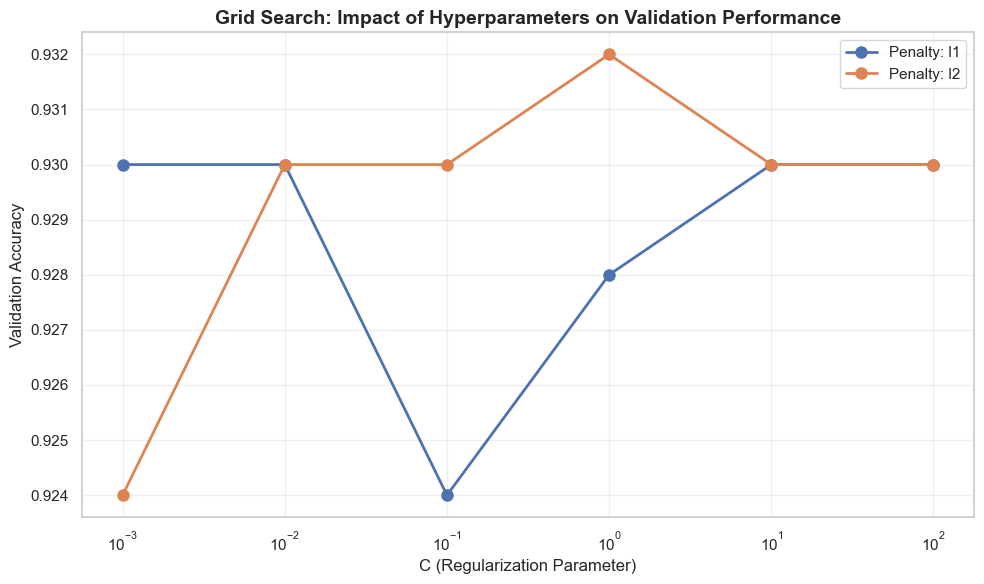

In [47]:
results_df = pd.DataFrame(results)

# Plot validation scores for each penalty type
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

for penalty in param_grid['penalty']:
    mask = results_df['penalty'] == penalty
    data = results_df[mask].sort_values('C')
    ax.plot(data['C'], data['val_score'], 
            marker='o', label=f'Penalty: {penalty}', linewidth=2, markersize=8)

ax.set_xlabel('C (Regularization Parameter)', fontsize=12)
ax.set_ylabel('Validation Accuracy', fontsize=12)
ax.set_title('Grid Search: Impact of Hyperparameters on Validation Performance', 
             fontsize=14, fontweight='bold')
ax.set_xscale('log')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

From the results, we can see that the best hyperparameters are `C=1` and `penalty='l2'`, achieving a validation accuracy of **0.932**.

print("Higher C = weaker regularization (more complex model)")

__`Step 25`__ Train final model with best parameters and evaluate on test set

Now that we've selected the best hyperparameters using the validation set, we can:
1. Retrain on **train + validation** combined (to use more data)
2. Evaluate on the **test set** for an unbiased performance estimate

In [48]:
# Create model with best hyperparameters
best_model = LogisticRegression(**best_params, max_iter=1000)

# Train on train+val combined for final model
final_model, final_scaler, final_fill_values = run_model(
    X_train_val,  # Use all training+validation data
    y_train_val,
    scaler=StandardScaler(),
    model=best_model,
    fill_method='median'
)

# Evaluate on test set
test_score = evaluate_model(X_test, y_test, final_model, final_scaler, final_fill_values)

print("Final Model Evaluation")
print(f"Best parameters: {best_params}")
print(f"Validation score: {best_score:.4f}")
print(f"Test score: {test_score:.4f}")
print(f"Difference: {abs(best_score - test_score):.4f}")
print("\nIf test score is close to validation score, assuming the data in validation and test is similar, our model should generalize well!")

Final Model Evaluation
Best parameters: {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
Validation score: 0.9320
Test score: 0.9380
Difference: 0.0060

If test score is close to validation score, assuming the data in validation and test is similar, our model should generalize well!


---

## The Complete Model Selection Workflow

Step-by-step process:

1. **Split Your Data** (Section 2): Create train, validation, and test sets. Use stratification for classification problems. Keep the test set completely separate.

2. **Choose a Cross-Validation Strategy** (Section 3): K-Fold for standard cases, Stratified K-Fold for imbalanced data, Repeated K-Fold for robust estimates, PredefinedSplit when you have fixed train-val sets.

3. **Compare Different Algorithms (and different hyperparameter combinations)** (Sections 4 and 5): Train multiple models (Logistic Regression, Decision Trees, etc.). Use the same CV strategy for fair comparison. Check both train and validation scores.

5. **Final Evaluation**: Evaluate your best model on the test set exactly once. Compare test score to validation score - large differences suggest overfitting.

---

## Extra: Grid Search with Cross-Validation

Now that we've seen grid search with both holdout and K-Fold CV, let's implement a complete grid search using cross-validation with our `avg_score` function. This example shows how to systematically test hyperparameters while preventing data leakage.

__`Step 26`__ Implement grid search with K-Fold cross-validation

In [49]:
# Define parameter grid
param_grid_cv = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

# Store results for each combination
cv_search_results = []

# Create Stratified K-Fold cross-validator
kf_search = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("Grid Search with 5-Fold Cross-Validation")
print(f"Testing {len(param_grid_cv['C']) * len(param_grid_cv['penalty'])} combinations\n")

# Loop through all parameter combinations
for C in param_grid_cv['C']:
    for penalty in param_grid_cv['penalty']:
        # Track scores across folds for this combination
        fold_scores = []
        
        # Perform CV
        for fold, (train_idx, val_idx) in enumerate(kf_search.split(X_train_val, y_train_val)):
            X_fold_train = X_train_val.iloc[train_idx]
            y_fold_train = y_train_val.iloc[train_idx]
            X_fold_val = X_train_val.iloc[val_idx]
            y_fold_val = y_train_val.iloc[val_idx]
            
            # Create and train model with preprocessing
            model = LogisticRegression(C=C, penalty=penalty, solver='liblinear', max_iter=1000)
            trained_model, fitted_scaler, fill_values = run_model(
                X_fold_train, y_fold_train,
                scaler=StandardScaler(),
                model=model,
                fill_method='median'
            )
            
            # Evaluate on validation fold
            fold_score = evaluate_model(X_fold_val, y_fold_val, trained_model, fitted_scaler, fill_values)
            fold_scores.append(fold_score)
        
        # Calculate mean CV score
        mean_cv_score = np.mean(fold_scores)
        std_cv_score = np.std(fold_scores)
        
        cv_search_results.append({
            'C': C,
            'penalty': penalty,
            'mean_score': mean_cv_score,
            'std_score': std_cv_score
        })
        
        print(f"C={C:5.2f}, penalty={penalty:2s} -> Mean CV Score: {mean_cv_score:.4f} (+/- {std_cv_score:.4f})")

# Find best parameters
best_result = max(cv_search_results, key=lambda x: x['mean_score'])
print(f"\nBest Parameters: C={best_result['C']}, penalty={best_result['penalty']}")
print(f"Best CV Score: {best_result['mean_score']:.4f} (+/- {best_result['std_score']:.4f})")

Grid Search with 5-Fold Cross-Validation
Testing 8 combinations

C= 0.01, penalty=l1 -> Mean CV Score: 0.9300 (+/- 0.0000)
C= 0.01, penalty=l2 -> Mean CV Score: 0.9330 (+/- 0.0033)
C= 0.10, penalty=l1 -> Mean CV Score: 0.9335 (+/- 0.0051)
C= 0.10, penalty=l2 -> Mean CV Score: 0.9330 (+/- 0.0019)
C= 1.00, penalty=l1 -> Mean CV Score: 0.9350 (+/- 0.0042)
C= 1.00, penalty=l2 -> Mean CV Score: 0.9345 (+/- 0.0046)
C=10.00, penalty=l1 -> Mean CV Score: 0.9340 (+/- 0.0049)
C=10.00, penalty=l2 -> Mean CV Score: 0.9340 (+/- 0.0049)

Best Parameters: C=1, penalty=l1
Best CV Score: 0.9350 (+/- 0.0042)


__`Step 27`__ Train final model with best parameters from CV grid search

In [50]:
# Train final model with best parameters on full train_val set
final_model_params = LogisticRegression(
    C=best_result['C'], 
    penalty=best_result['penalty'], 
    solver='liblinear', 
    max_iter=1000
)

final_trained, final_scaler, final_fills = run_model(
    X_train_val, y_train_val,
    scaler=StandardScaler(),
    model=final_model_params,
    fill_method='median'
)

# Evaluate on test set
final_test_score = evaluate_model(X_test, y_test, final_trained, final_scaler, final_fills)

print("\nFinal Model Performance:")
print(f"CV Score: {best_result['mean_score']:.4f}")
print(f"Test Score: {final_test_score:.4f}")
print(f"Difference: {abs(best_result['mean_score'] - final_test_score):.4f}")


Final Model Performance:
CV Score: 0.9350
Test Score: 0.9380
Difference: 0.0030


---

## Scikit-learn Hyperparameter Optimization Tools

While we've implemented grid search manually to understand the process and prevent data leakage, scikit-learn provides several tools for hyperparameter optimization. These tools can be very useful, but be careful that implementing them correctly without data leakage is extremely difficult.

### Available Optimization Methods

| Class | Description | Use Case | Documentation |
|-------|-------------|----------|---------------|
| **GridSearchCV** | Exhaustive search over parameter grid | Small parameter spaces, guaranteed to find best in grid | [Link](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) |
| **RandomizedSearchCV** | Random sampling from parameter distributions | Large parameter spaces, faster than grid search | [Link](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html) |
| **HalvingGridSearchCV** | Successive halving on parameter grid | Large datasets, eliminates poor candidates early | [Link](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.HalvingGridSearchCV.html) |
| **HalvingRandomSearchCV** | Successive halving with random sampling | Very large parameter spaces | [Link](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.HalvingRandomSearchCV.html) |
| **BayesSearchCV** | Bayesian optimization (requires scikit-optimize) | Expensive model training, smart parameter exploration | [Link](https://scikit-optimize.github.io/stable/modules/generated/skopt.BayesSearchCV.html) |
| **OptunaSearchCV** | Optuna-based optimization (requires optuna) | Advanced optimization with pruning | [Link](https://optuna.readthedocs.io/en/stable/reference/generated/optuna.integration.OptunaSearchCV.html) |

**Note:** The key to using these tools correctly is to ensure preprocessing is part of the model pipeline (see next section).

---

## Using Pipeline with GridSearchCV

The safest way to use scikit-learn's GridSearchCV (or RandomSearchCV - which is **better in most scenarios**) is to combine it with **Pipeline**. A Pipeline ensures that all preprocessing steps are applied correctly during cross-validation, preventing data leakage.

__`Step 28`__ Implement Grid Search using Pipeline and GridSearchCV

In [51]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV

# Create a pipeline that includes all preprocessing and modeling steps
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),  # Fill NaN values
    ('scaler', StandardScaler()),                    # Scale features
    ('classifier', LogisticRegression(max_iter=1000)) # Model
])

# Define parameter grid (note the naming: step_name__parameter_name)
param_grid_pipeline = {
    'classifier__C': [0.01, 0.1, 1, 10],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__solver': ['liblinear']
}

# Create GridSearchCV with the pipeline
grid_search = GridSearchCV(
    pipeline,
    param_grid_pipeline,
    cv=5,  # 5-fold cross-validation
    scoring='accuracy',
    verbose=1,
    n_jobs=-1  # Use all available cores
)

# Fit on train_val data
print("Running GridSearchCV with Pipeline...")
grid_search.fit(X_train_val, y_train_val)

print("\nGridSearchCV Results:")
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best CV score: {grid_search.best_score_:.4f}")

# The best model is already trained on full train_val data
test_score_pipeline = grid_search.score(X_test, y_test)
print(f"Test score: {test_score_pipeline:.4f}")

Running GridSearchCV with Pipeline...
Fitting 5 folds for each of 8 candidates, totalling 40 fits

GridSearchCV Results:
Best parameters: {'classifier__C': 0.1, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
Best CV score: 0.9350
Test score: 0.9380


__`Step 29`__ Compare Results (They should be the same)

In [52]:
# Compare with our manual approach
print(f"\n{'Method':<30} {'Test Score':<12}")
print("-" * 42)
print(f"{'Manual Grid Search Implementation (avg_score)':<30} {final_test_score:.4f}")
print(f"{'Pipeline + GridSearchCV':<30} {test_score_pipeline:.4f}")
print("\nBoth approaches prevent data leakage and give similar results.")


Method                         Test Score  
------------------------------------------
Manual Grid Search Implementation (avg_score) 0.9380
Pipeline + GridSearchCV        0.9380

Both approaches prevent data leakage and give similar results.
